In [1]:
import obspy
import math
import glob
from obspy import UTCDateTime as UTC
import datetime
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
from math import sin, cos, sqrt, atan2, radians
from scipy import signal,stats
from scipy.interpolate import griddata
import h5py
import os
import pickle
import csv
from sklearn.linear_model import LinearRegression,Lasso
import pandas as pd
from obspy.signal.trigger import classic_sta_lta,trigger_onset,plot_trigger
import time
from matplotlib.patches import Rectangle 
from matplotlib.offsetbox import AnchoredText

In [2]:
def obspy_filter(data,lowcut,highcut,fs,order=4):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    z, p, k = signal.iirfilter(order, [low, high], btype='band',
                        ftype='butter', output='zpk')
    sos = signal.zpk2sos(z, p, k)
    new_data=signal.sosfilt(sos, data)
    return new_data

In [3]:
### panel A

counts=np.zeros(9600)

infos=np.sort(glob.glob('/nfs/turbo/lsa-zspica/work/yaolinm/Japan_detection/final_catalog_14s/WSS/uncataloged_info/*.pkl'))
for info in infos:
    with open(info,'rb') as f:
        infodic=pickle.load(f)
    counts[np.array(infodic['Matched_channels'])]+=1

In [4]:
### panel B

times=[]

infos=np.sort(glob.glob('/nfs/turbo/lsa-zspica/work/yaolinm/Japan_detection/final_catalog_14s/WSS/uncataloged_info/*.pkl'))
for info in infos:
    with open(info,'rb') as f:
        infodic=pickle.load(f)
        if 3078 in infodic['Matched_channels']:
            times.append(float(UTC(infodic['Detection_time'])))

In [5]:
nchs_all=[]

for info in infos:
    with open(info,'rb') as f:
        infodic=pickle.load(f)
    nchs_all.append(len(infodic['Matched_channels']))

In [6]:
valid_event=[]
pos=[]

for i in range(len(infos)):
    info=infos[i]
    with open(info,'rb') as f:
        infodic=pickle.load(f)
    if 3078 in infodic['Matched_channels']:
        valid_event.append(i)
        pos.append(infodic['Matched_channels'].index(3078))
print(len(valid_event))

1279


In [151]:
files=0

while files<len(infos):
   
    npys=np.sort(glob.glob('/nfs/turbo/lsa-zspica/work/yaolinm/Japan_detection/final_catalog_14s/WSS/uncataloged_waveforms/*.npy'))
    files=len(npys)
    print(files,'files')
    time.sleep(10)
    
print(len(npys),'files')

df=np.zeros((len(valid_event),6000))
for i in range(len(valid_event)):
    print(i)
    npy=np.load(npys[valid_event[i]])
    tr=npy[pos[i],:]
    tr=obspy_filter(tr,1,8,100)
    df[i,:]=tr
    
np.save('/scratch/zspica_root/zspica0/yaolinm/Japan/uncataloged/uncataloged_tr.npy',df)

3312 files
3644 files
3858 files
3994 files
4169 files
4372 files
4531 files
4703 files
4868 files
5302 files
5469 files
5652 files
5804 files
5959 files
6125 files
6282 files
6423 files
6583 files
6769 files
7066 files
7168 files
7322 files
7464 files
7801 files
7917 files
8048 files
8160 files
8335 files
8443 files
8534 files
8625 files
8708 files
8789 files
8941 files
9006 files
9092 files
9151 files
9233 files
9265 files
9305 files
9347 files
9380 files
9405 files
9424 files
9439 files
9452 files
9465 files
9472 files
9479 files
9485 files
9487 files
9489 files
9489 files
9490 files
9490 files
9490 files
9492 files
9492 files
9494 files
9494 files
9495 files
9495 files
9495 files
9495 files
9496 files
9497 files
9497 files
9497 files
9498 files
9499 files
9499 files
9499 files
9500 files
9500 files
9501 files
9502 files
9502 files
9503 files
9504 files
9505 files
9506 files
9508 files
9509 files
9510 files
9511 files
9511 files
9512 files
9513 files
9513 files
0
1
2
3
4
5
6
7
8
9
1

In [7]:
df=np.load('/scratch/zspica_root/zspica0/yaolinm/Japan/uncataloged/uncataloged_tr.npy')

In [8]:
def shift_stack_matrix(matrix,reference=0):
    
    tr=matrix[reference,:]/np.max(matrix[reference,:])
    stacked=np.zeros_like(tr)
    ref=np.argmax(tr)
    
    for i in range(1,len(matrix)):
        temp_tr=matrix[i,:]/np.max(matrix[i,:])
        stacked+=np.roll(temp_tr,-(np.argmax(temp_tr)-ref))
        
    return stacked

def shift_tr(tr,time,sampling_rate=25):
    
    omega=np.fft.fftfreq(len(tr),1/sampling_rate)*2*np.pi
    
    return np.fft.ifft(np.fft.fft(tr)*np.exp(-1j*omega*time)).real

def cc_and_stack(tr1,tr2):
        
    cc=np.fft.ifft(np.fft.fft(tr1)*np.conj(np.fft.fft(tr2))).real
    delta=np.argmax(cc)
    full_tr2=np.roll(tr2,-delta)
    
    return full_tr2

def cc_stack_matrix(matrix,reference=0,threshold=0.4):
    
    tr1=matrix[reference,:]
    stacked=np.zeros_like(tr1)
    c=0
    for i in range(len(matrix)):
        if stats.pearsonr(tr1,matrix[i,:])[0]>threshold:
            stacked+=cc_and_stack(tr1,matrix[i,:])
            c+=1
        
    return stacked

import scipy.cluster.hierarchy as sch
def cluster_corr(corr_array, inplace=False):

    pairwise_distances = sch.distance.pdist(corr_array)
    linkage = sch.linkage(pairwise_distances, method='complete')
    cluster_distance_threshold = pairwise_distances.max()/2
    idx_to_cluster_array = sch.fcluster(linkage, cluster_distance_threshold, 
                                        criterion='distance')
    idx = np.argsort(idx_to_cluster_array)
    
    if not inplace:
        corr_array = corr_array.copy()
    
    if isinstance(corr_array, pd.DataFrame):
        return corr_array.iloc[idx, :].T.iloc[idx, :]
    return corr_array[idx, :][:, idx], idx

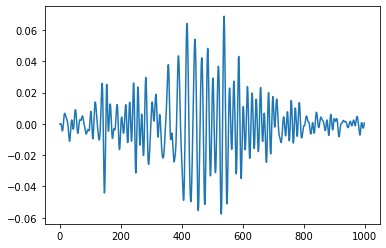

In [9]:
temp_df=np.load('/nfs/turbo/lsa-zspica/work/yaolinm/Japan_detection/Yaolin_N30_catalog/WSS/uncataloged_incomplete_waveform/OBDAS02835.npy')
temp=obspy_filter(temp_df[195,4500:5500],2,8,100)
plt.plot(temp)

In [10]:
partial_df=np.zeros((len(df),1000))
for i in range(len(df)):
    print(i)
    tr=obspy_filter(df[i,:],2,8,100)
    scores=[]
    for j in range(5000):
        scores.append(stats.pearsonr(temp,tr[j:j+1000])[0])
    partial_df[i,:]=tr[np.argmax(scores):1000+np.argmax(scores)]

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [25]:
np.save('partial_df.npy',partial_df)

In [11]:
corrs=np.abs(np.corrcoef(partial_df))
sorted_corrs,idx=cluster_corr(corrs)

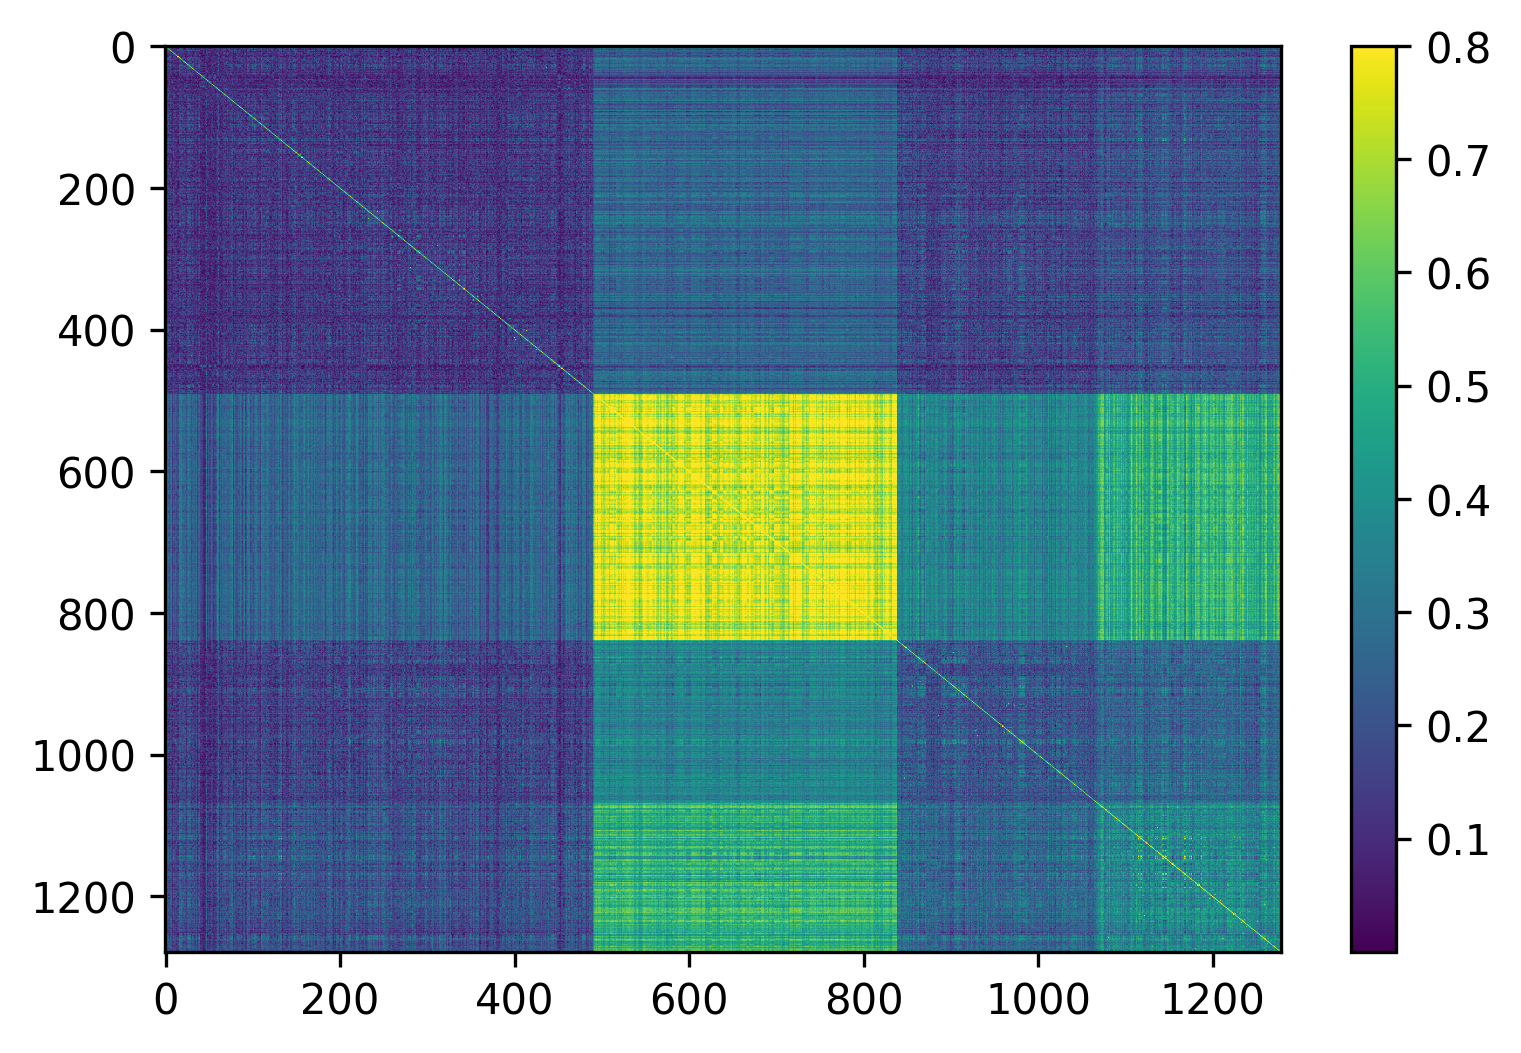

In [12]:
plt.figure(dpi=300)
plt.imshow(sorted_corrs,aspect='auto',vmax=0.8)
plt.colorbar()

In [13]:
c=0
highcc_times=[]
tobe_stacked=np.zeros((387,1000))
for i in range(len(idx)):
    if stats.pearsonr(partial_df[idx[i],:],temp)[0]>0.6:  
        tobe_stacked[c,:]=partial_df[idx[i],:]
        highcc_times.append(times[idx[i]])
        c+=1
c

387

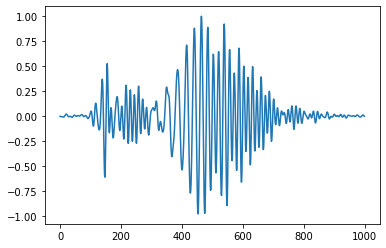

In [14]:
stacked=np.sum(tobe_stacked,axis=0)
plt.plot(stacked/np.max(np.abs(stacked)))

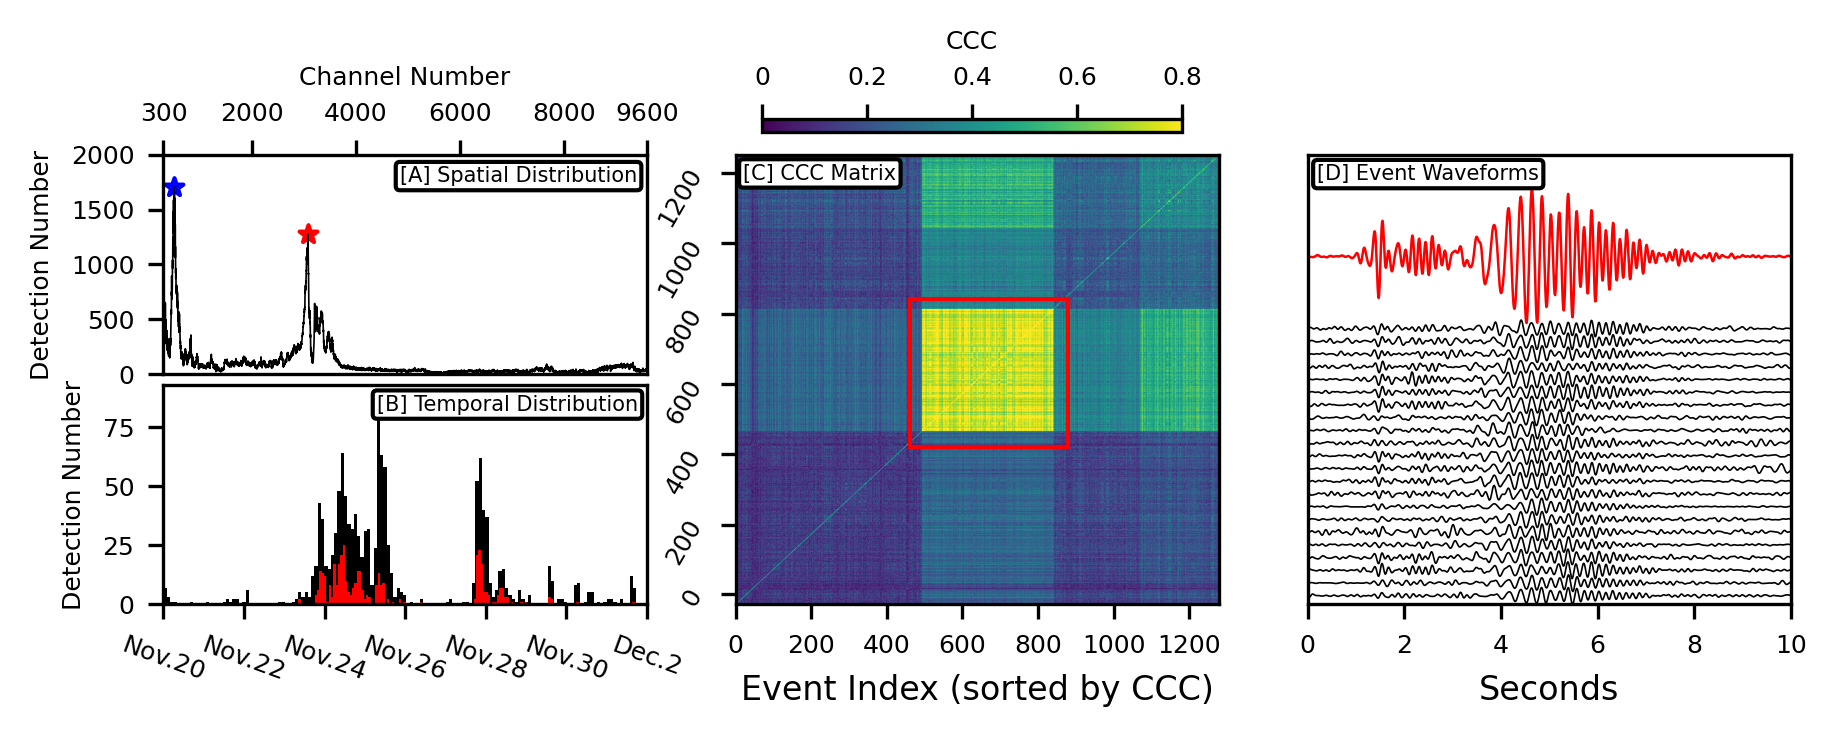

In [15]:
fig=plt.figure(figsize=(7,3),dpi=300)
fig.subplots_adjust(hspace=0.1,wspace=0.45)

ax1 = plt.subplot2grid(shape=(6,6), loc=(0,0), colspan=2,rowspan=2)
ax2 = plt.subplot2grid(shape=(6,6), loc=(2,0), colspan=2,rowspan=2)
ax3 = plt.subplot2grid(shape=(6,6), loc=(0,2), colspan=2,rowspan=4)
ax4 = plt.subplot2grid(shape=(6,6), loc=(0,4), colspan=2,rowspan=4)

ax1.plot(counts,linewidth=0.4,c='k',label='Total SSS detections')
ax1.scatter(3078,counts[3078],marker='*',s=20,c='r')
ax1.scatter(503,counts[503],marker='*',s=20,c='b')
ax1.set_ylabel('Detection Number',fontsize=6)
ax1.set_xlim(300,9600)
ax1.set_ylim(0,2000)
ax1.set_xticks([300,2000,4000,6000,8000,9600])
ax1.set_xticklabels([300,2000,4000,6000,8000,9600],fontsize=6)
ax1.text(4850,1750,'[A] Spatial Distribution',bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.2'),c='k',fontsize=5)
ax1.set_xlabel('Channel Number',fontsize=6)
ax1.tick_params(top=True, labeltop=True, bottom=False, labelbottom=False)
ax1.xaxis.set_label_position('top')
ax1.tick_params(axis='both', labelsize=6)

_,_,_=ax2.hist(times, bins=144,color='k')
_,_,_=ax2.hist(highcc_times, bins=144,color='r')
ax2.set_ylabel('Detection Number',fontsize=6)
ax2.set_ylim(0,93)
ax2.set_xticks(np.arange(0,12.1,2)*24*3600+times[0])
ax2.set_xticklabels(['Nov.20','Nov.22','Nov.24','Nov.26','Nov.28','Nov.30','Dec.2'],fontsize=6,rotation=-20)
ax2.text(times[0]+5.3*24*3600,82,'[B] Temporal Distribution',bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.2'),c='k',fontsize=5)
ax2.set_xlim(times[0],times[0]+12*24*3600)
ax2.tick_params(axis='y', labelsize=6)

mesh=ax3.imshow(np.flip(sorted_corrs,axis=0),aspect='auto',vmin=0,vmax=0.8)

ax3.add_patch(Rectangle((460,410),420,420,fc='none',ec='r',lw=1))

ax3.set_xticks([0,200,400,600,800,1000,1200])
ax3.set_xticklabels([0,200,400,600,800,1000,1200],fontsize=6)
ax3.set_yticks([52,252,452,652,852,1052,1250])
ax3.set_yticklabels([1200,1000,800,600,400,200,0],fontsize=6,rotation=60)
ax3.set_xlabel('Event Index (sorted by CCC)',fontsize=8)
ax3.text(20,70,'[C] CCC Matrix',bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.2'),c='k',fontsize=5)

ax4.plot(40*stacked/np.max(np.abs(stacked))+200,linewidth=0.6,c='r',)
for i in range(0,330,15):
    ax4.plot(5*tobe_stacked[i,:]/np.max(np.abs(tobe_stacked[i,:]))+i/2,linewidth=0.4,c='k',)
ax4.set_xlim(0,1000)
ax4.set_ylim(-5,260)
ax4.text(20,245,'[D] Event Waveforms',bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.2'),c='k',fontsize=5)
ax4.set_yticks([])
ax4.set_xticks([0,200,400,600,800,1000])
ax4.set_xticklabels([0,2,4,6,8,10],fontsize=6)
ax4.set_xlabel('Seconds',fontsize=8)

cax=fig.add_axes([0.41,0.905,0.2,0.015])
cbar=fig.colorbar(mesh, cax=cax,orientation='horizontal')
cbar.set_ticks([0,0.2,0.4,0.6,0.8])
cbar.set_ticklabels([0,0.2,0.4,0.6,0.8])
cbar.ax.tick_params(labelsize=6)
cbar.ax.xaxis.set_ticks_position('top')
cbar.ax.xaxis.set_label_position('top')
cbar.set_label('CCC',fontsize=6)

# section 1

In [16]:
valid_event2=[]
pos2=[]

for i in range(len(infos)):
    info=infos[i]
    with open(info,'rb') as f:
        infodic=pickle.load(f)
    if 503 in infodic['Matched_channels']:
        valid_event2.append(i)
        pos2.append(infodic['Matched_channels'].index(503))
print(len(valid_event2))

1704


In [17]:
times2=[]

infos=np.sort(glob.glob('/nfs/turbo/lsa-zspica/work/yaolinm/Japan_detection/final_catalog_14s/WSS/uncataloged_info/*.pkl'))
for info in infos:
    with open(info,'rb') as f:
        infodic=pickle.load(f)
        if 503 in infodic['Matched_channels']:
            times2.append(float(UTC(infodic['Detection_time'])))

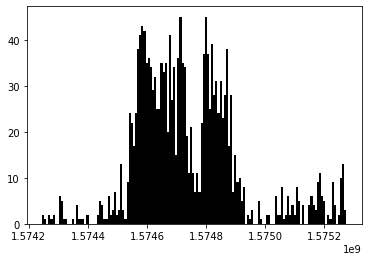

In [18]:
_,_,_=plt.hist(times2, bins=144,color='k')

In [19]:
df2_38=np.load('/scratch/zspica_root/zspica0/yaolinm/Japan/uncataloged/uncataloged_tr_section0_38.npy')
df2_18=np.load('/scratch/zspica_root/zspica0/yaolinm/Japan/uncataloged/uncataloged_tr_section0_18.npy')
df2_raw=np.load('/scratch/zspica_root/zspica0/yaolinm/Japan/uncataloged/uncataloged_tr_section0_raw.npy')

In [140]:
npys=np.sort(glob.glob('/nfs/turbo/lsa-zspica/work/yaolinm/Japan_detection/final_catalog_14s/WSS/uncataloged_waveforms/*.npy'))
df2_38=np.zeros((len(valid_event2),6000))
df2_18=np.zeros((len(valid_event2),6000))

for i in range(len(valid_event2)):
    print(i)
    npy=np.load(npys[valid_event2[i]])
    tr=npy[pos2[i],:]
    tr_copy=tr.copy()
    df2_38[i,:]=obspy_filter(tr,3,8,100)
    df2_18[i,:]=obspy_filter(tr_copy,1,8,100)
    
np.save('/scratch/zspica_root/zspica0/yaolinm/Japan/uncataloged/uncataloged_tr_section0_38.npy',df2_38)
np.save('/scratch/zspica_root/zspica0/yaolinm/Japan/uncataloged/uncataloged_tr_section0_18.npy',df2_18)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [149]:
df2_raw=np.zeros((len(valid_event2),6000))

for i in range(len(valid_event2)):
    print(i)
    npy=np.load(npys[valid_event2[i]])
    df2_raw[i,:]=npy[pos2[i],:]
np.save('/scratch/zspica_root/zspica0/yaolinm/Japan/uncataloged/uncataloged_tr_section0_raw.npy',df2_raw)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [20]:
folders=np.sort(glob.glob('/nfs/turbo/lsa-zspica/work/yaolinm/from_scratch/temp_25Hz/*'))

for folder in folders:
    
    mseeds=np.sort(glob.glob(folder+'/*.mseed'))
    
    if folder==folders[0]:
        data=obspy.read(mseeds[5])[3].data
    else:
        data=np.concatenate((data,obspy.read(mseeds[5])[3].data))
    
    print(folder)

/nfs/turbo/lsa-zspica/work/yaolinm/from_scratch/temp_25Hz/000hr
/nfs/turbo/lsa-zspica/work/yaolinm/from_scratch/temp_25Hz/001hr
/nfs/turbo/lsa-zspica/work/yaolinm/from_scratch/temp_25Hz/002hr
/nfs/turbo/lsa-zspica/work/yaolinm/from_scratch/temp_25Hz/003hr
/nfs/turbo/lsa-zspica/work/yaolinm/from_scratch/temp_25Hz/004hr
/nfs/turbo/lsa-zspica/work/yaolinm/from_scratch/temp_25Hz/005hr
/nfs/turbo/lsa-zspica/work/yaolinm/from_scratch/temp_25Hz/006hr
/nfs/turbo/lsa-zspica/work/yaolinm/from_scratch/temp_25Hz/007hr
/nfs/turbo/lsa-zspica/work/yaolinm/from_scratch/temp_25Hz/008hr
/nfs/turbo/lsa-zspica/work/yaolinm/from_scratch/temp_25Hz/009hr
/nfs/turbo/lsa-zspica/work/yaolinm/from_scratch/temp_25Hz/010hr
/nfs/turbo/lsa-zspica/work/yaolinm/from_scratch/temp_25Hz/011hr
/nfs/turbo/lsa-zspica/work/yaolinm/from_scratch/temp_25Hz/012hr
/nfs/turbo/lsa-zspica/work/yaolinm/from_scratch/temp_25Hz/013hr
/nfs/turbo/lsa-zspica/work/yaolinm/from_scratch/temp_25Hz/014hr
/nfs/turbo/lsa-zspica/work/yaolinm/from_

/nfs/turbo/lsa-zspica/work/yaolinm/from_scratch/temp_25Hz/129hr
/nfs/turbo/lsa-zspica/work/yaolinm/from_scratch/temp_25Hz/130hr
/nfs/turbo/lsa-zspica/work/yaolinm/from_scratch/temp_25Hz/131hr
/nfs/turbo/lsa-zspica/work/yaolinm/from_scratch/temp_25Hz/132hr
/nfs/turbo/lsa-zspica/work/yaolinm/from_scratch/temp_25Hz/133hr
/nfs/turbo/lsa-zspica/work/yaolinm/from_scratch/temp_25Hz/134hr
/nfs/turbo/lsa-zspica/work/yaolinm/from_scratch/temp_25Hz/135hr
/nfs/turbo/lsa-zspica/work/yaolinm/from_scratch/temp_25Hz/136hr
/nfs/turbo/lsa-zspica/work/yaolinm/from_scratch/temp_25Hz/137hr
/nfs/turbo/lsa-zspica/work/yaolinm/from_scratch/temp_25Hz/138hr
/nfs/turbo/lsa-zspica/work/yaolinm/from_scratch/temp_25Hz/139hr
/nfs/turbo/lsa-zspica/work/yaolinm/from_scratch/temp_25Hz/140hr
/nfs/turbo/lsa-zspica/work/yaolinm/from_scratch/temp_25Hz/141hr
/nfs/turbo/lsa-zspica/work/yaolinm/from_scratch/temp_25Hz/142hr
/nfs/turbo/lsa-zspica/work/yaolinm/from_scratch/temp_25Hz/143hr
/nfs/turbo/lsa-zspica/work/yaolinm/from_

/nfs/turbo/lsa-zspica/work/yaolinm/from_scratch/temp_25Hz/258hr
/nfs/turbo/lsa-zspica/work/yaolinm/from_scratch/temp_25Hz/259hr
/nfs/turbo/lsa-zspica/work/yaolinm/from_scratch/temp_25Hz/260hr
/nfs/turbo/lsa-zspica/work/yaolinm/from_scratch/temp_25Hz/261hr
/nfs/turbo/lsa-zspica/work/yaolinm/from_scratch/temp_25Hz/262hr
/nfs/turbo/lsa-zspica/work/yaolinm/from_scratch/temp_25Hz/263hr
/nfs/turbo/lsa-zspica/work/yaolinm/from_scratch/temp_25Hz/264hr
/nfs/turbo/lsa-zspica/work/yaolinm/from_scratch/temp_25Hz/265hr
/nfs/turbo/lsa-zspica/work/yaolinm/from_scratch/temp_25Hz/266hr
/nfs/turbo/lsa-zspica/work/yaolinm/from_scratch/temp_25Hz/267hr
/nfs/turbo/lsa-zspica/work/yaolinm/from_scratch/temp_25Hz/268hr
/nfs/turbo/lsa-zspica/work/yaolinm/from_scratch/temp_25Hz/269hr
/nfs/turbo/lsa-zspica/work/yaolinm/from_scratch/temp_25Hz/270hr
/nfs/turbo/lsa-zspica/work/yaolinm/from_scratch/temp_25Hz/271hr
/nfs/turbo/lsa-zspica/work/yaolinm/from_scratch/temp_25Hz/272hr
/nfs/turbo/lsa-zspica/work/yaolinm/from_

In [21]:
sampling_rate=25
nperseg=int(120*sampling_rate)
nstep=int(60*sampling_rate)
length=len(data)//nperseg*nperseg-nstep
freqs=np.fft.fftfreq(int(nperseg),1/sampling_rate)

spectral=np.zeros((17277,3000))
for i in range(17277):
    spectral[i,:]=np.abs(np.fft.fft(data[i*nstep:nperseg+i*nstep]))**2

In [22]:
times2_rescaled=(np.array(times2)-np.min(times2))/60

In [23]:
freqs=np.fft.fftfreq(6000,1/100)[:3000]
def normalize(data):
    return data/np.max(np.abs(data))

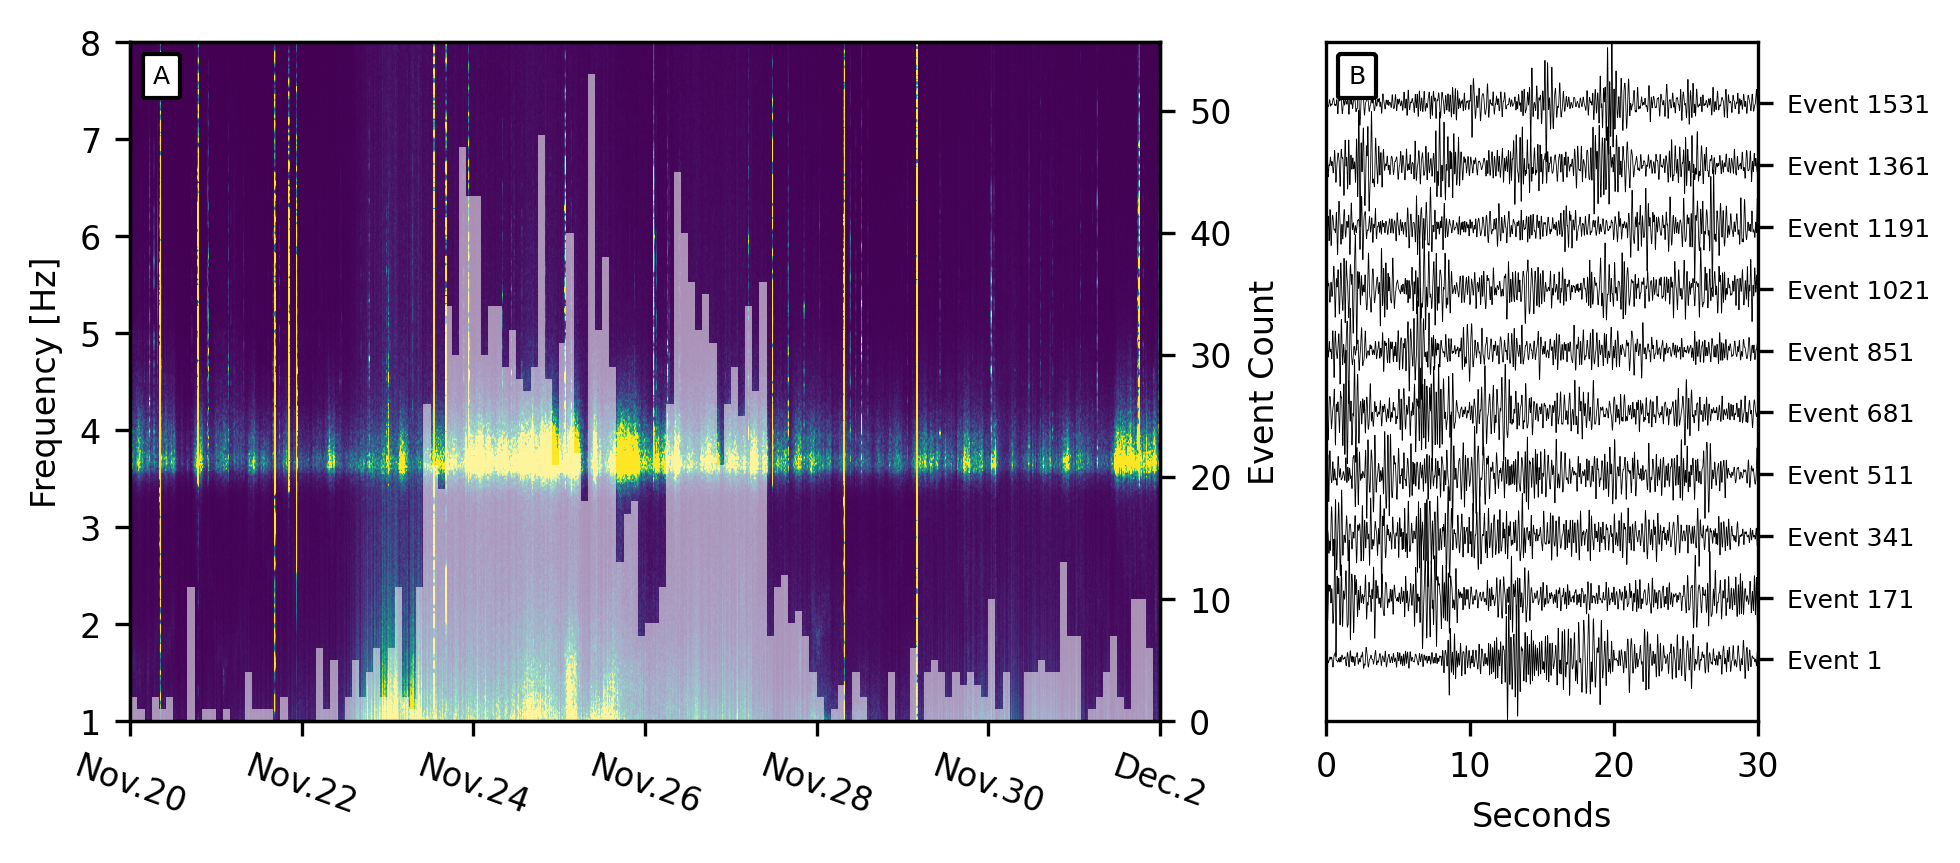

In [24]:
fig=plt.figure(figsize=(7,3),dpi=300)
fig.subplots_adjust(hspace=1,wspace=1.25)
ax1 = plt.subplot2grid(shape=(6,6), loc=(0,0), colspan=4,rowspan=6)
ax2 = plt.subplot2grid(shape=(6,6), loc=(0,4), colspan=2,rowspan=6)

ax_twin = ax1.twinx() 
ax1.imshow(spectral[:,2520:2940].T,aspect='auto',vmax=3*10**9)
_,_,_=ax_twin.hist(times2_rescaled, bins=np.arange(0,17277,120),color='w',alpha=0.55)

ax1.set_yticks([0,60,120,180,240,300,360,420])
ax1.set_yticklabels([8,7,6,5,4,3,2,1],fontsize=8)
ax1.set_ylabel('Frequency [Hz]',fontsize=8)
ax1.set_xticks([0,2880,2880*2,2880*3,2880*4,2880*5,2880*6])
ax1.set_xticklabels(['Nov.20','Nov.22','Nov.24','Nov.26','Nov.28','Nov.30','Dec.2'],fontsize=8,rotation=-20)
ax_twin.set_ylabel('Event Count',fontsize=8)
ax_twin.set_yticks([0,10,20,30,40,50])
ax_twin.set_yticklabels([0,10,20,30,40,50],fontsize=8)

ax2.set_yticks([])

for i in range(1,10*170+1,170):
    ax2.plot(normalize(df2_38[i,1500:4500])+i/170,lw=0.2,c='k')
ax2.set_ylim(-1,10)
ax2.set_xlim(0,3000)
ax2.set_xticks([0,1000,2000,3000])
ax2.set_xticklabels([0,10,20,30],fontsize=8)
ax2.set_xlabel('Seconds',fontsize=8)
ax2.yaxis.set_label_position("right")
ax2.yaxis.tick_right()
ax2.set_yticks([9,8,7,6,5,4,3,2,1,0])
ax2.set_yticklabels(['Event 1531','Event 1361','Event 1191','Event 1021','Event 851','Event 681','Event 511','Event 341','Event 171','Event 1'],fontsize=6)

at=AnchoredText('A',prop=dict(size=6), frameon=True,loc=2)
at.patch.set_boxstyle('round',pad=0,rounding_size=0.1)
ax1.add_artist(at)

at=AnchoredText('B',prop=dict(size=6), frameon=True,loc=2)
at.patch.set_boxstyle('round',pad=0,rounding_size=0.1)
ax2.add_artist(at)

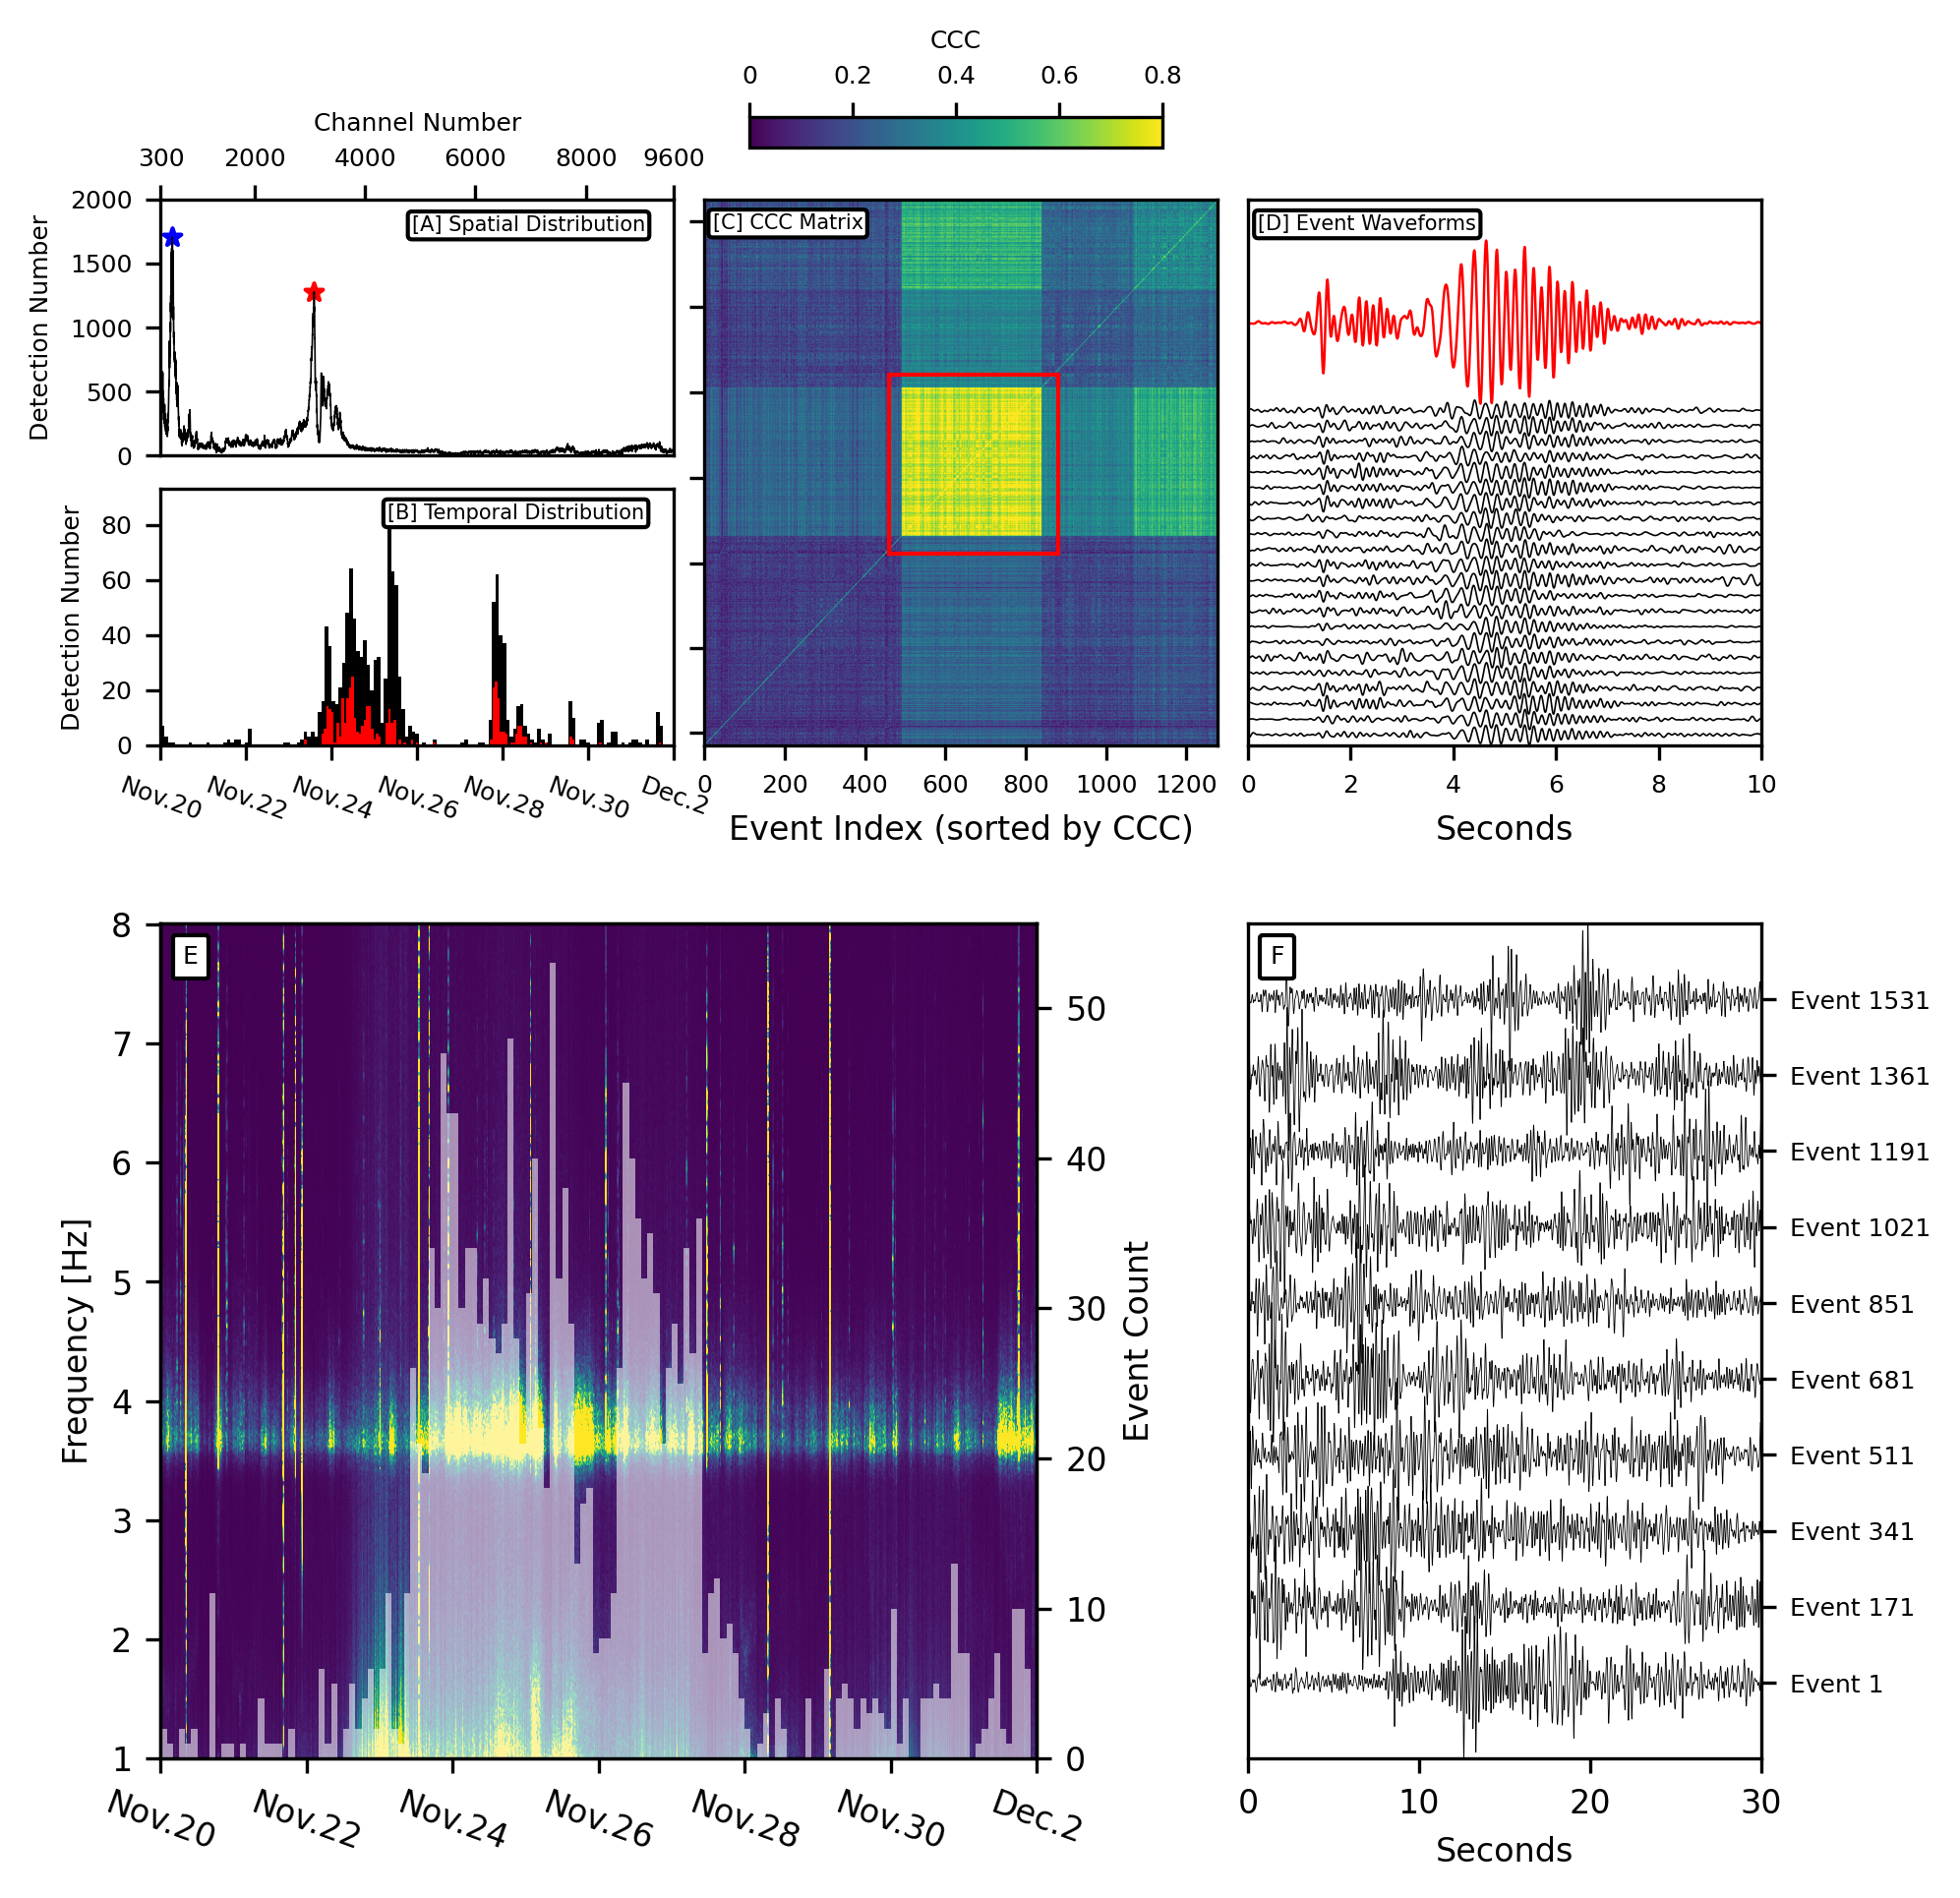

In [47]:
fig=plt.figure(figsize=(7,7),dpi=300)
fig.subplots_adjust(hspace=0.3,wspace=0.2)

ax1 = plt.subplot2grid(shape=(11,9), loc=(0,0), colspan=3,rowspan=2)
ax2 = plt.subplot2grid(shape=(11,9), loc=(2,0), colspan=3,rowspan=2)
ax3 = plt.subplot2grid(shape=(11,9), loc=(0,3), colspan=3,rowspan=4)
ax4 = plt.subplot2grid(shape=(11,9), loc=(0,6), colspan=3,rowspan=4)
ax5 = plt.subplot2grid(shape=(11,9), loc=(5,0), colspan=5,rowspan=6)
ax6 = plt.subplot2grid(shape=(11,9), loc=(5,6), colspan=3,rowspan=6)

ax1.plot(counts,linewidth=0.4,c='k',label='Total SSS detections')
ax1.scatter(3078,counts[3078],marker='*',s=20,c='r')
ax1.scatter(503,counts[503],marker='*',s=20,c='b')
ax1.set_ylabel('Detection Number',fontsize=6)
ax1.set_xlim(300,9600)
ax1.set_ylim(0,2000)
ax1.set_xticks([300,2000,4000,6000,8000,9600])
ax1.set_xticklabels([300,2000,4000,6000,8000,9600],fontsize=6)
ax1.text(4850,1750,'[A] Spatial Distribution',bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.2'),c='k',fontsize=5)
ax1.set_xlabel('Channel Number',fontsize=6)
ax1.tick_params(top=True, labeltop=True, bottom=False, labelbottom=False)
ax1.xaxis.set_label_position('top')
ax1.tick_params(axis='both', labelsize=6)

_,_,_=ax2.hist(times, bins=144,color='k')
_,_,_=ax2.hist(highcc_times, bins=144,color='r')
ax2.set_ylabel('Detection Number',fontsize=6)
ax2.set_ylim(0,93)
ax2.set_xticks(np.arange(0,12.1,2)*24*3600+times[0])
ax2.set_xticklabels(['Nov.20','Nov.22','Nov.24','Nov.26','Nov.28','Nov.30','Dec.2'],fontsize=6,rotation=-20)
ax2.text(times[0]+5.3*24*3600,82,'[B] Temporal Distribution',bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.2'),c='k',fontsize=5)
ax2.set_xlim(times[0],times[0]+12*24*3600)
ax2.tick_params(axis='y', labelsize=6)

mesh=ax3.imshow(np.flip(sorted_corrs,axis=0),aspect='auto',vmin=0,vmax=0.8)

ax3.add_patch(Rectangle((460,410),420,420,fc='none',ec='r',lw=1))

ax3.set_xticks([0,200,400,600,800,1000,1200])
ax3.set_xticklabels([0,200,400,600,800,1000,1200],fontsize=6)
ax3.set_yticks([52,252,452,652,852,1052,1250])
ax3.set_yticklabels(['','','','','','',''],fontsize=6,rotation=60)
ax3.set_xlabel('Event Index (sorted by CCC)',fontsize=8)
ax3.text(20,70,'[C] CCC Matrix',bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.2'),c='k',fontsize=5)

ax4.plot(40*stacked/np.max(np.abs(stacked))+200,linewidth=0.6,c='r',)
for i in range(0,330,15):
    ax4.plot(5*tobe_stacked[i,:]/np.max(np.abs(tobe_stacked[i,:]))+i/2,linewidth=0.4,c='k',)
ax4.set_xlim(0,1000)
ax4.set_ylim(-5,260)
ax4.text(20,245,'[D] Event Waveforms',bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.2'),c='k',fontsize=5)
ax4.set_yticks([])
ax4.set_xticks([0,200,400,600,800,1000])
ax4.set_xticklabels([0,2,4,6,8,10],fontsize=6)
ax4.set_xlabel('Seconds',fontsize=8)

cax=fig.add_axes([0.41,0.905,0.2,0.015])
cbar=fig.colorbar(mesh, cax=cax,orientation='horizontal')
cbar.set_ticks([0,0.2,0.4,0.6,0.8])
cbar.set_ticklabels([0,0.2,0.4,0.6,0.8])
cbar.ax.tick_params(labelsize=6)
cbar.ax.xaxis.set_ticks_position('top')
cbar.ax.xaxis.set_label_position('top')
cbar.set_label('CCC',fontsize=6)

ax_twin = ax5.twinx() 
ax5.imshow(spectral[:,2520:2940].T,aspect='auto',vmax=3*10**9)
_,_,_=ax_twin.hist(times2_rescaled, bins=np.arange(0,17277,120),color='w',alpha=0.55)

ax5.set_yticks([0,60,120,180,240,300,360,420])
ax5.set_yticklabels([8,7,6,5,4,3,2,1],fontsize=8)
ax5.set_ylabel('Frequency [Hz]',fontsize=8)
ax5.set_xticks([0,2880,2880*2,2880*3,2880*4,2880*5,2880*6])
ax5.set_xticklabels(['Nov.20','Nov.22','Nov.24','Nov.26','Nov.28','Nov.30','Dec.2'],fontsize=8,rotation=-20)
ax_twin.set_ylabel('Event Count',fontsize=8)
ax_twin.set_yticks([0,10,20,30,40,50])
ax_twin.set_yticklabels([0,10,20,30,40,50],fontsize=8)

ax6.set_yticks([])

for i in range(1,10*170+1,170):
    ax6.plot(normalize(df2_38[i,1500:4500])+i/170,lw=0.2,c='k')
ax6.set_ylim(-1,10)
ax6.set_xlim(0,3000)
ax6.set_xticks([0,1000,2000,3000])
ax6.set_xticklabels([0,10,20,30],fontsize=8)
ax6.set_xlabel('Seconds',fontsize=8)
ax6.yaxis.set_label_position("right")
ax6.yaxis.tick_right()
ax6.set_yticks([9,8,7,6,5,4,3,2,1,0])
ax6.set_yticklabels(['Event 1531','Event 1361','Event 1191','Event 1021','Event 851','Event 681','Event 511','Event 341','Event 171','Event 1'],fontsize=6)

at=AnchoredText('E',prop=dict(size=6), frameon=True,loc=2)
at.patch.set_boxstyle('round',pad=0,rounding_size=0.1)
ax5.add_artist(at)

at=AnchoredText('F',prop=dict(size=6), frameon=True,loc=2)
at.patch.set_boxstyle('round',pad=0,rounding_size=0.1)
ax6.add_artist(at)